contour detection

In [2]:
import cv2
import os

def process_and_save_contours(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    # Walk through the input folder's subfolders and files
    for root, subfolders, files in os.walk(input_folder):
        for subfolder in subfolders:
            subfolder_path = os.path.join(root, subfolder)
            output_subfolder_path = os.path.join(output_folder, subfolder)
            
            # Create corresponding subfolder in output directory
            if not os.path.exists(output_subfolder_path):
                os.makedirs(output_subfolder_path)
                
            # Process each image in the subfolder
            for file in os.listdir(subfolder_path):
                input_image_path = os.path.join(subfolder_path, file)
                output_image_path = os.path.join(output_subfolder_path, file)
                
                # Read and process the image (extracting contours)
                image = cv2.imread(input_image_path)
                if image is None:
                    print(f"Could not read {input_image_path}. Skipping...")
                    continue
                
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                blurred = cv2.GaussianBlur(gray, (5, 5), 0)     # Apply Gaussian blur
                _, thresh = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)  # Thresholding
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Create a blank grayscale image to draw contours on
                contour_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # To allow contour drawing in grayscale
                cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)  # Draw white contours
                
                # Convert the resulting image back to pure grayscale for saving
                contour_image_gray = cv2.cvtColor(contour_image, cv2.COLOR_BGR2GRAY)
                
                # Save the grayscale contour image
                cv2.imwrite(output_image_path, contour_image_gray)
                print(f"Processed and saved: {output_image_path}")

# Provide input and output folder paths here
input_folder = "./Dataset"   # Path to the main folder with subfolders (classes)
output_folder = "./Dataset_contures_gray"  # Path where you want to save contour images

process_and_save_contours(input_folder, output_folder)


Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_145957 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150000 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150308 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150310 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150314 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150321 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150324 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150331 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150335 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150341 (Custom).jpg
Processed and saved: ./Dataset_contures_gray/Diseased/IMG_20211212_150345 (Custom).jpg
Processed and saved: ./Dataset_contures_gra

In [3]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import local_binary_pattern
import joblib 

from skimage.feature import hog

def process_image(image_path, image_size=32):
    """
    Reads, resizes, and preprocesses a grayscale contour image.
    Extracts features including flattened pixels, LBP, Hu Moments, and HOG.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None

    # Resize image to a fixed size (32x32)
    image_resized = cv2.resize(image, (image_size, image_size))
    image_normalized = image_resized / 255.0  # Normalize pixel intensities

    # Flattened pixel intensities
    flat_features = image_normalized.flatten()

    # Convert to uint8 for LBP and HOG
    image_uint8 = (image_normalized * 255).astype(np.uint8)

    # Extract Local Binary Pattern (LBP) features
    radius = 2
    n_points = 8 * radius
    lbp = local_binary_pattern(image_uint8, n_points, radius, method="uniform")
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    lbp_hist_normalized = lbp_hist.astype("float") / lbp_hist.sum()

    # Extract Hu Moments (shape-based features)
    moments = cv2.moments(image_normalized)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Extract HOG features (captures shape and texture)
    hog_features, _ = hog(image_uint8, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                          block_norm='L2-Hys', visualize=True)

    # Concatenate all features (pixels, LBP, Hu Moments, HOG)
    combined_features = np.concatenate([flat_features, lbp_hist_normalized, hu_moments, hog_features])

    return combined_features



def load_dataset(input_folder):
    """
    Loads all images from subfolders, extracts features, and assigns labels.
    Assumes each subfolder name represents a class label.
    """
    features = []
    labels = []
    feature_length = None  # Keep track of feature vector length
    
    for subfolder in os.listdir(input_folder):
        subfolder_path = os.path.join(input_folder, subfolder)
        if os.path.isdir(subfolder_path):
            print(f"Processing class: {subfolder}")
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                image_features = process_image(file_path)
                if image_features is not None:
                    if feature_length is None:
                        feature_length = len(image_features)
                    elif len(image_features) != feature_length:
                        continue  # Skip this image if feature length is inconsistent
                    features.append(image_features)
                    labels.append(subfolder)  # Use subfolder name as the class label
    
    return np.array(features), np.array(labels)


def balance_dataset(features, labels):
    """
    Balances the dataset by undersampling the majority class.
    """
    # Separate the classes
    diseased_features = features[labels == "Diseased"]
    healthy_features = features[labels == "Healthy"]

    # Calculate the size of the smaller class
    min_samples = min(len(diseased_features), len(healthy_features))

    # Undersample the majority class to balance the dataset
    diseased_features_downsampled = resample(diseased_features, 
                                             replace=False,  # Without replacement
                                             n_samples=min_samples, 
                                             random_state=42)

    healthy_features_downsampled = resample(healthy_features, 
                                            replace=False,
                                            n_samples=min_samples, 
                                            random_state=42)

    # Combine the balanced datasets
    balanced_features = np.vstack((diseased_features_downsampled, healthy_features_downsampled))
    balanced_labels = np.array(["Diseased"] * min_samples + ["Healthy"] * min_samples)

    return balanced_features, balanced_labels

from sklearn.ensemble import RandomForestClassifier
def train_and_evaluate(features, labels):
    """
    Splits the dataset, trains an SVM classifier, and evaluates the model.
    """
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train an SVM classifier
    svm_model = RandomForestClassifier() #SVC(kernel='linear')
    print("Training the SVM classifier on balanced data...")
    svm_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = svm_model.predict(X_test)
    accuracy = svm_model.score(X_test, y_test)
    joblib.dump(svm_model, 'randomforest.pkl') 
    print(f"SVM Accuracy: {accuracy * 100:.2f}%")

    # Display classification report and confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


if __name__ == "__main__":
    input_folder = "./Dataset_contures_gray"

    print("Loading dataset and extracting features...")
    features, labels = load_dataset(input_folder)

    # Convert labels to NumPy array for easier manipulation
    labels = np.array(labels)

    # Balance the dataset by undersampling the majority class
    print("Balancing the dataset...")
    balanced_features, balanced_labels = balance_dataset(features, labels)

    # Train and evaluate the model on the balanced dataset
    train_and_evaluate(balanced_features, balanced_labels)


Loading dataset and extracting features...
Processing class: Diseased
Processing class: Healthy
Balancing the dataset...
Training the SVM classifier on balanced data...
SVM Accuracy: 86.00%

Confusion Matrix:
[[76 20]
 [ 8 96]]

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.90      0.79      0.84        96
     Healthy       0.83      0.92      0.87       104

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# def train_random_forest(X_train, y_train):
#     """
#     Trains a Random Forest Classifier with hyperparameter tuning using GridSearchCV.
#     """
#     rf = RandomForestClassifier('criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100)

    # # Define hyperparameters to tune
    # param_grid = {
    #     'n_estimators': [50, 100, 200],
    #     'max_depth': [10, 20, 30, None],
    #     'max_features': ['sqrt', 'log2', None],
    #     'criterion': ['gini', 'entropy']
    # }

    # grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')
    # grid_search.fit(X_train, y_train)

    # print(f"Best Parameters: {grid_search.best_params_}")
    # return grid_search.best_estimator_

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


def train_model(xtrain, ytrain):
    models = [RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', criterion='entropy'), SVC(kernel='poly'),LogisticRegression()]
    accuracys = {}
    for model in models:
        model.fit(xtrain, ytrain)
        model.score(xtrain, ytrain)
        accuracys[type(model).__name__] = model.score(xtrain, ytrain) * 100

    return accuracys
    


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

if __name__ == "__main__":
    input_folder = "./Dataset_contures_gray"

    print("Loading dataset and extracting features...")
    features, labels = load_dataset(input_folder)

    labels = np.array(labels)

    # Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # print("Training Random Forest with hyperparameter tuning...")
    # best_rf_model = train_model(X_train, y_train)

    # # Evaluate the model
    # y_pred = best_rf_model.predict(X_test)
    # accuracy = best_rf_model.score(X_test, y_test)
    # print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

    # print("\nConfusion Matrix:")
    # print(confusion_matrix(y_test, y_pred))
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_pred))

    accuracys = train_model(X_train, y_train)


Loading dataset and extracting features...
Processing class: Diseased
Processing class: Healthy


/home/kafi/miniforge3/envs/mango/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


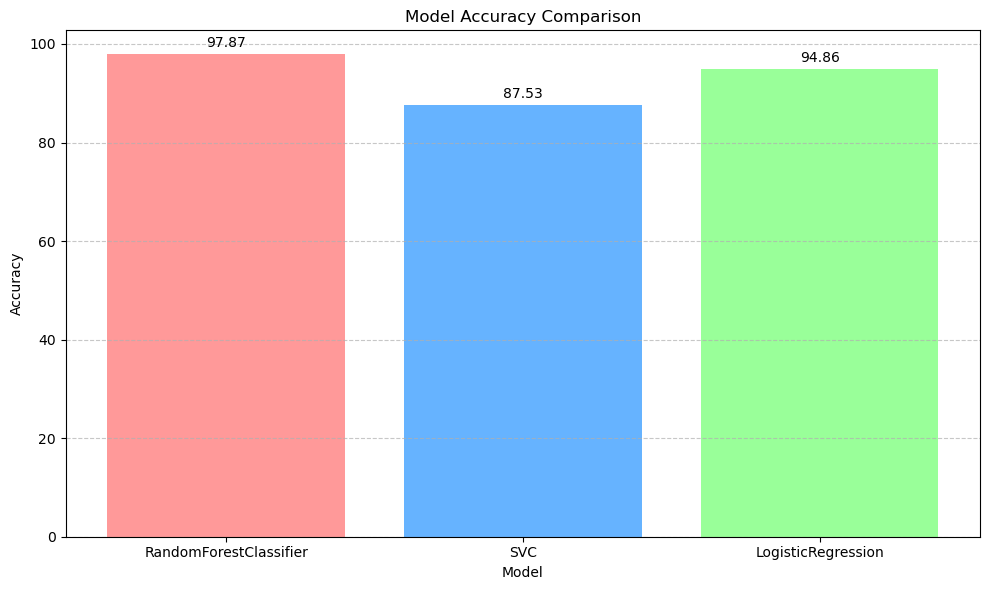

In [32]:
import matplotlib.pyplot as plt
# Create bar chart

fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 6)
bars = ax.bar(accuracys.keys(), accuracys.values(), color=['#ff9999','#66b3ff','#99ff99'])

# Add annotations
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Add labels and title
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Accuracy Comparison')

# Customize ticks
plt.xticks()

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

if __name__ == "__main__":
    input_folder = "./Dataset_contures_gray"

    print("Loading dataset and extracting features...")
    features, labels = load_dataset(input_folder)

    labels = np.array(labels)

    # Split dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', criterion='entropy')
    model.fit(X_train, y_train)

Loading dataset and extracting features...
Processing class: Diseased
Processing class: Healthy


In [4]:
# Generate predictions for the test set
y_pred = model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.88      1.00      0.94       696
     Healthy       1.00      0.08      0.15       102

    accuracy                           0.88       798
   macro avg       0.94      0.54      0.54       798
weighted avg       0.90      0.88      0.84       798



In [35]:
import joblib
joblib.dump(model, "model.pkl")

['model.pkl']

In [38]:
model.predict([X_test[0]])

array(['Diseased'], dtype='<U8')

### Steamlit test

In [ ]:
import cv2
import numpy as np
import streamlit as st
from skimage.feature import hog, local_binary_pattern

def extract_features_from_streamlit(uploaded_file, image_size=32):
    """
    Takes an uploaded image from Streamlit, preprocesses it, and extracts a feature vector.
    The vector includes flattened pixels, LBP histogram, Hu Moments, and HOG features.
    """
    # Load the image from the uploaded file as grayscale
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)

    if image is None:
        st.error("Error: Could not load the image.")
        return None

    # Resize and normalize the image
    image_resized = cv2.resize(image, (image_size, image_size))
    image_normalized = image_resized / 255.0  # Normalize pixel intensities

    # Flatten pixel intensities
    flat_features = image_normalized.flatten()

    # Convert to uint8 for LBP and HOG extraction
    image_uint8 = (image_normalized * 255).astype(np.uint8)

    # Extract Local Binary Pattern (LBP) features
    radius = 2
    n_points = 8 * radius
    lbp = local_binary_pattern(image_uint8, n_points, radius, method="uniform")
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    lbp_hist_normalized = lbp_hist.astype("float") / lbp_hist.sum()

    # Extract Hu Moments (shape-based features)
    moments = cv2.moments(image_normalized)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Extract HOG features
    hog_features, _ = hog(image_uint8, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                          block_norm='L2-Hys', visualize=True)

    # Concatenate all features (pixel intensities, LBP, Hu Moments, and HOG)
    combined_features = np.concatenate([flat_features, lbp_hist_normalized, hu_moments, hog_features])

    # Return the combined feature vector
    return combined_features
